## Load and explore Yelp reviews dataset

In [5]:
import tarfile
import json
import folium
from tqdm import tqdm
from IPython.display import display
import random
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
tar_path = 'data/Yelp JSON/yelp_dataset.tar'
extract_path = 'data/yelp_dataset'

with tarfile.open(tar_path, 'r') as tar:
    tar.extractall(path=extract_path)

/var/folders/05/cjcx_y2d6h1gpmvcb422p0pr0000gn/T/ipykernel_75745/2286915978.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_path)


In [7]:
def load_all_business_locations(business_file):
    """
    Load all business entries with latitude and longitude from Yelp dataset.

    Args:
        business_file (str): Path to business.json

    Returns:
        list of dict: Entries with lat/lon
    """
    businesses = []
    with open(business_file, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading businesses"):
            biz = json.loads(line)
            if biz.get('latitude') is not None and biz.get('longitude') is not None:
                businesses.append({
                    'name': biz['name'],
                    'latitude': biz['latitude'],
                    'longitude': biz['longitude'],
                    'city': biz.get('city', ''),
                    'state': biz.get('state', ''),
                    'categories': biz.get('categories', '')
                })
    return businesses

def plot_all_businesses_on_map(businesses, center=(36.1699, -115.1398), zoom=4, sample_size=1000):
    """
    Plot a random sample of business coordinates on a folium map.

    Args:
        businesses (list): List of business dicts with lat/lon
        center (tuple): Initial center of the map
        zoom (int): Initial zoom level
        sample_size (int): Number of businesses to sample for plotting

    Returns:
        folium.Map
    """
    sampled = random.sample(businesses, min(sample_size, len(businesses)))

    m = folium.Map(location=center, zoom_start=zoom)

    for b in sampled:
        folium.CircleMarker(
            location=(b['latitude'], b['longitude']),
            radius=2,
            color='blue',
            fill=True,
            fill_opacity=0.6,
            popup=f"{b['name']} ({b['city']})"
        ).add_to(m)

    return m

In [8]:
# Load first 5000 businesses (to avoid crowding map)
businesses = load_all_business_locations("data/yelp_dataset/yelp_academic_dataset_business.json")
print(f"Total businesses with coordinates: {len(businesses)}")

Loading businesses: 150346it [00:00, 234181.99it/s]

Total businesses with coordinates: 150346


In [12]:
# Visualize
m = plot_all_businesses_on_map(businesses, center=(36.1699, -115.1398), zoom=4, sample_size=1000)
display(m)

Philadelphia: 14570
Tucson: 9252
Tampa: 9051
Indianapolis: 7543
Nashville: 6974
New Orleans: 6209
Reno: 5937
Edmonton: 5054
Saint Louis: 4828
Santa Barbara: 3834
Boise: 2938
Clearwater: 2221
Saint Petersburg: 1663
Metairie: 1644
Sparks: 1625
Wilmington: 1448
Franklin: 1415
St. Louis: 1255
St. Petersburg: 1185
Meridian: 1044


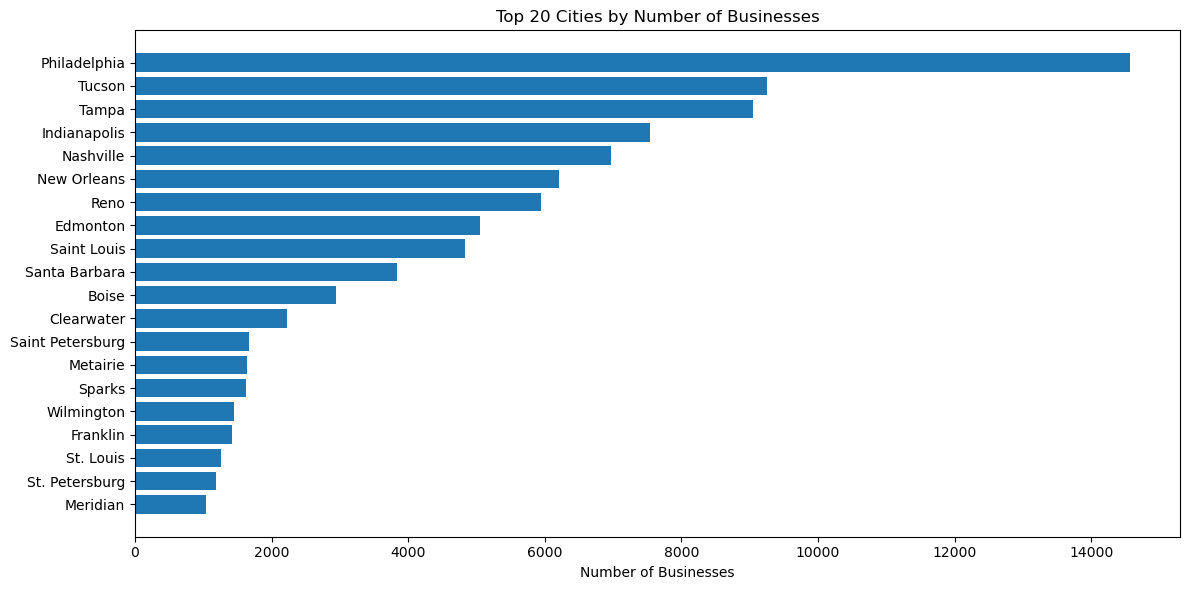

In [13]:
def count_businesses_by_city(businesses):
    
    city_counter = Counter()
    for b in businesses:
        city = b.get('city', '').strip()
        if city:  # Exclude empty city names
            city_counter[city] += 1
    return city_counter

city_counts = count_businesses_by_city(businesses)

top_n = 20 
for city, count in city_counts.most_common(top_n):
    print(f"{city}: {count}")

df = pd.DataFrame(city_counts.most_common(top_n), columns=['City', 'Count'])

plt.figure(figsize=(12, 6))
plt.barh(df['City'], df['Count'])
plt.gca().invert_yaxis()  # Highest count on top
plt.xlabel("Number of Businesses")
plt.title(f"Top {top_n} Cities by Number of Businesses")
plt.tight_layout()
plt.show()

## Load reviews of the given city

In [14]:
import json

def load_reviews_by_city(business_file, review_file, city_name, max_reviews=1000):
    """
    Load Yelp reviews for businesses located in a specific city.

    Args:
        business_file (str): Path to the business.json file.
        review_file (str): Path to the review.json file.
        city_name (str): Target city name (case-insensitive match).
        max_reviews (int): Maximum number of reviews to return.

    Returns:
        list of dict: Filtered review entries with location info.
    """
    business_ids_in_city = {}

    # First, load businesses in the target city
    with open(business_file, 'r', encoding='utf-8') as f:
        for line in f:
            biz = json.loads(line)
            if biz.get('city', '').strip().lower() == city_name.strip().lower():
                business_ids_in_city[biz['business_id']] = {
                    'name': biz['name'],
                    'latitude': biz.get('latitude'),
                    'longitude': biz.get('longitude'),
                    'categories': biz.get('categories', ''),
                    'city': biz.get('city', '')
                }

    # Then, load reviews for those businesses
    reviews = []
    with open(review_file, 'r', encoding='utf-8') as f:
        for line in f:
            review = json.loads(line)
            biz_id = review['business_id']
            if biz_id in business_ids_in_city:
                # Combine review with business info
                review_data = {
                    'business_id': biz_id,
                    'business_name': business_ids_in_city[biz_id]['name'],
                    'text': review['text'],
                    'stars': review['stars'],
                    'date': review['date'],
                    'latitude': business_ids_in_city[biz_id]['latitude'],
                    'longitude': business_ids_in_city[biz_id]['longitude']
                }
                reviews.append(review_data)
                if len(reviews) >= max_reviews:
                    break

    return reviews

In [15]:
business_path = "data/yelp_dataset/yelp_academic_dataset_business.json"
review_path = "data/yelp_dataset/yelp_academic_dataset_review.json"

city_name = 'Indianapolis'
reviews = load_reviews_by_city(business_path, 
                                review_path,
                                city_name=city_name,
                                max_reviews=1000)

print(f"Loaded {len(reviews)} reviews from {city_name}.")

Loaded 1000 reviews from Indianapolis.


In [16]:
reviews[0]

{'business_id': 'EQ-TZ2eeD_E0BHuvoaeG5Q',
 'business_name': 'Milktooth',
 'text': "Locals recommended Milktooth, and it's an amazing jewel of Indianapolis. I'm glade I had the chance to experience this.",
 'stars': 4.0,
 'date': '2015-08-19 14:31:45',
 'latitude': 39.7591692208,
 'longitude': -86.146494347}

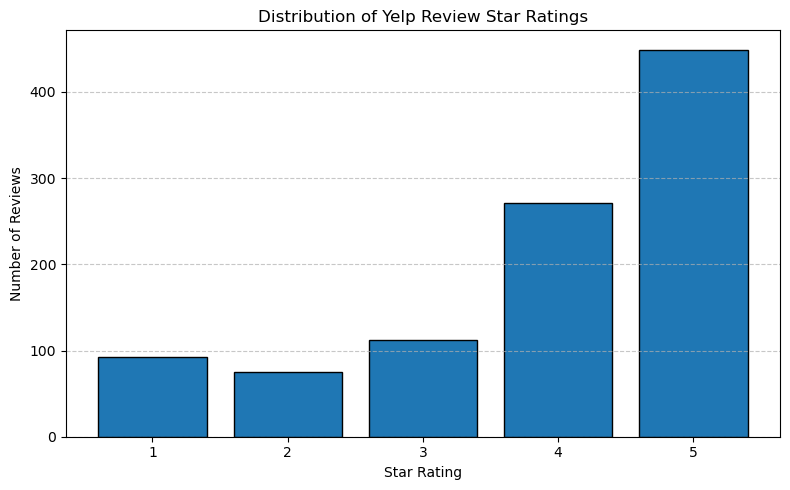

In [17]:
def plot_star_distribution(reviews):
    stars = [review['stars'] for review in reviews]

    plt.figure(figsize=(8, 5))
    plt.hist(stars, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], edgecolor='black', rwidth=0.8)
    plt.xticks([1, 2, 3, 4, 5])
    plt.xlabel("Star Rating")
    plt.ylabel("Number of Reviews")
    plt.title("Distribution of Yelp Review Star Ratings")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
plot_star_distribution(reviews)

In [18]:
from folium.plugins import HeatMap

def plot_review_heatmap(reviews, map_center=None, zoom_start=11):
    # Prepare location points
    heat_data = [
        [review['latitude'], review['longitude']]
        for review in reviews
        if review['latitude'] is not None and review['longitude'] is not None
    ]

    if not heat_data:
        print("No valid location data to plot.")
        return

    # If no center provided, use mean location
    if map_center is None:
        avg_lat = sum(p[0] for p in heat_data) / len(heat_data)
        avg_lon = sum(p[1] for p in heat_data) / len(heat_data)
        map_center = (avg_lat, avg_lon)

    # Create folium map
    m = folium.Map(location=map_center, zoom_start=zoom_start)
    HeatMap(heat_data, radius=10, blur=15).add_to(m)

    return m

m = plot_review_heatmap(reviews)
m

## Initialize and test LLM API

In [40]:
import getpass
import os

if not os.getenv("DEEPSEEK_API_KEY"):
    os.environ["DEEPSEEK_API_KEY"] = getpass.getpass("Enter your DeepSeek API key: ")

In [41]:
from langchain_deepseek import ChatDeepSeek

llm = ChatDeepSeek(
    model="deepseek-chat",
    temperature=0.5,
    max_tokens=2048,          
    timeout=30,                
    max_retries=3,             
)

# Helper function to call LLM and display result
def ask_llm(prompt):
    print(f"\n📌 Prompt:\n{prompt}\n")
    for chunk in llm.stream(prompt):
        print(chunk.text(), end="")
    print("\n")

def generate_multiple_outputs(prompt, temperature=1.0, num_outputs=3):
    # build a new llm object
    llm_temp = ChatDeepSeek(
        model="deepseek-chat",              
        temperature=temperature,          # setting temperature
        max_tokens=2048,          
        timeout=30,                
        max_retries=3,             
        api_key=api_key,
    )
    
    print(f"Prompt: {prompt}")
    print(f"Temperature: {temperature}")
    print(f"Generating {num_outputs} outputs...\n")
    
    for i in range(num_outputs):
        print(f"\n📌 Prompt:\n{prompt}\n")
        for chunk in llm_temp.stream(prompt):
            print(chunk.text(), end="")
        print("\n")

In [42]:
# Test connection
test = ["Is 9.9 or 9.11 bigger?"]
ask_llm(test)


📌 Prompt:
['Is 9.9 or 9.11 bigger?']

To determine which number is larger between **9.9** and **9.11**, let's compare them step by step.

### Step 1: Align the Decimal Places
First, it's helpful to write both numbers with the same number of decimal places for easier comparison.

- **9.9** can be written as **9.90**
- **9.11** remains **9.11**

### Step 2: Compare the Whole Number Part
Both numbers have the same whole number part:

- **9** (for both 9.90 and 9.11)

Since the whole numbers are equal, we proceed to compare the decimal parts.

### Step 3: Compare the Tenths Place
- **9.90** has a **9** in the tenths place.
- **9.11** has a **1** in the tenths place.

Since **9 > 1**, we can conclude that **9.90** is greater than **9.11**.

### Final Answer
\[
\boxed{9.9 \text{ is larger than } 9.11}
\]



## Structure output using LLM

In [51]:
import time

def analyze_reviews(reviews, llm, output_csv, max_reviews=50, sleep_time=0.2):
    """
    Analyze Yelp reviews with DeepSeek API to extract polarity, sentiment, and keywords.
    Save results to a CSV file.

    Args:
        reviews (list): List of review dicts, each must have key 'text'.
        output_csv (str): Output CSV path.
        max_reviews (int): Max number of reviews to process.
        sleep_time (float): Delay between API calls to avoid rate limiting.
    """
    reviews = list(reviews)[:max_reviews]
    results = []

    for review in tqdm(reviews, total=len(reviews)):
        review_text = review['text'].replace('\n', ' ').strip()
        
        prompt = f"""
You are an assistant performing structured sentiment analysis on Yelp reviews.

Please analyze the following review and extract:

1. polarity: One of "positive", "negative", or "neutral".
2. sentiment: Choose the most appropriate emotion from the list: "delighted", "content", "surprise", “indifferent”, "disappointed", "angry", or "frustrated".
3. keywords: Extract 2 to 5 important keywords that describe the main topics or aspects mentioned (e.g., cleanliness, service, location, waiting time).

Review: "{review_text}"

Return your answer strictly in the following JSON format:
{{
  "polarity": "...",
  "sentiment": "...",
  "keywords": ["...", "...", "..."]
}}
        """.strip()

        try:
            full_response = ""
            for chunk in llm.stream(prompt):
                full_response += chunk.text()

            # find JSON and extract
            json_start = full_response.find('{')
            json_end = full_response.rfind('}') + 1
            json_str = full_response[json_start:json_end]

            data = json.loads(json_str)

            results.append({
                "review_text": review_text,
                "polarity": data.get("polarity"),
                "sentiment": data.get("sentiment"),
                "keywords": ", ".join(data.get("keywords", [])),
                "stars": review.get("stars"),
                "business_name": review.get("business_name"),
                "latitude": review.get("latitude"),
                "longitude": review.get("longitude")
            })

        except Exception as e:
            print(f"\n Error processing review: {e}")
            continue

        time.sleep(sleep_time)  

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)
    print(f"\n Saved {len(df)} analyzed reviews to {output_csv}")
    return df

In [72]:
test_csv = "output/test.csv"
test = reviews[:5]
test_result = analyze_reviews(test, llm, test_csv)

100%|███████████████████████████████████████████████| 5/5 [00:32<00:00,  6.51s/it]


 Saved 5 analyzed reviews to output/test.csv


In [78]:
indy_csv = "output/indy.csv"
indy_result = analyze_reviews(reviews, llm, indy_csv, max_reviews=300)

100%|███████████████████████████████████████████| 300/300 [30:37<00:00,  6.12s/it]


 Saved 300 analyzed reviews to output/indy.csv


In [10]:
indy_result = pd.read_csv("output/indy.csv")
indy_result

review_text  polarity  sentiment  \
0    Locals recommended Milktooth, and it's an amaz...  positive  delighted   
1    I was really between 3 and 4 stars for this on...  positive    content   
2    I love the Brewpub for their variety of dishes...  positive    content   
3    I stopped here because it was by the hotel I w...  positive  delighted   
4    Milktooth is the place to go if you want a goo...  positive  delighted   
..                                                 ...       ...        ...   
295  The staff is very welcoming and the building i...  positive    content   
296  My dryer went out on the coldest day of the ye...  positive  delighted   
297  I appreciate Midas being open on the weekends....  positive    content   
298  The breakfast menu and pastry menu changes so ...  positive    content   
299  This is one of my new favorite summer, weekend...  positive  delighted   

                                              keywords  stars  \
0                       Milktooth, jewel, Indianapolis    4.0   
1                    sushi bowl, Maui roll, bubble tea    4.0   
2    variety of dishes, slow service, kid and dog f...    4.0   
3      friendly staff, buy one get one deal, hot wings    5.0   
4    breakfast cocktail, brunch, wait, Dutch pancak...    5.0   
..                                                 ...    ...   
295                     staff, building, doctors, dogs    5.0   
296                      attendant, clean, comfortable    5.0   
297       weekend service, fair price, quick diagnosis    4.0   
298             breakfast menu, quality, coffee, vibes    5.0   
299              dog-friendly, staff, Huevos rancheros    5.0   

                    business_name   latitude  longitude  
0                       Milktooth  39.759169 -86.146494  
1         Naked Tchopstix Express  39.912505 -86.211285  
2            Broad Ripple Brewpub  39.873580 -86.142783  
3                      Just Pizza  39.788154 -86.211698  
4                       Milktooth  39.759169 -86.146494  
..                            ...        ...        ...  
295  Pet Pals Holistic Veterinary  39.910906 -86.133207  
296                    Laundromat  39.874886 -86.119551  
297                         Midas  39.783846 -86.159893  
298                     Milktooth  39.759169 -86.146494  
299                 Biscuits Cafe  39.868795 -86.140713  

[300 rows x 8 columns]

## Heatmap based on polarity and sentiment classifications

In [38]:
# Heatmap based on polarity

# Define color mapping for polarity
polarity_color = {
    'positive': 'green',
    'neutral': 'orange',
    'negative': 'red'
}

# Create base map centered on Indianapolis
center_lat = indy_result['latitude'].mean()
center_lon = indy_result['longitude'].mean()
m_polarity = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Add individual markers (no clustering)
for _, row in indy_result.iterrows():
    polarity = row['polarity'].lower()
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=6,
        color=polarity_color.get(polarity, 'gray'),
        fill=True,
        fill_color=polarity_color.get(polarity, 'gray'),
        fill_opacity=0.8,
        popup=folium.Popup(
            f"<b>{row['business_name']}</b><br><i>{polarity.title()}</i><br>{row['review_text'][:150]}...",
            max_width=300
        )
    ).add_to(m_polarity)

# Show the map
m_polarity

In [39]:
# Heatmap based on sentiment classification

# Assign a unique color to each sentiment
sentiment_color = {
    'delighted': 'green',
    'content': 'lightgreen',
    'surprise': 'blue',
    'indifferent': 'grey',
    'disappointed': 'orange',
    'angry': 'red',
    'frustrated': 'purple'
}

# Create base map centered around the data
m_sentiment = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Add individual markers for each review with sentiment-specific color
for _, row in indy_result.iterrows():
    sentiment = row['sentiment'].lower()
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(
            f"<b>{row['business_name']}</b><br><b>{sentiment.title()}</b><br>{row['review_text'][:100]}...",
            max_width=300
        ),
        icon=folium.Icon(color=sentiment_color.get(sentiment, 'gray'), icon='info-sign')
    ).add_to(m_sentiment)

# Display the map
m_sentiment

/var/folders/05/cjcx_y2d6h1gpmvcb422p0pr0000gn/T/ipykernel_75745/114814116.py:26: UserWarning: color argument of Icon should be one of: {'beige', 'lightred', 'purple', 'red', 'gray', 'lightgray', 'green', 'darkpurple', 'blue', 'orange', 'pink', 'lightblue', 'white', 'darkgreen', 'cadetblue', 'black', 'lightgreen', 'darkblue', 'darkred'}.
  icon=folium.Icon(color=sentiment_color.get(sentiment, 'gray'), icon='info-sign')


## Validation on LLM output 

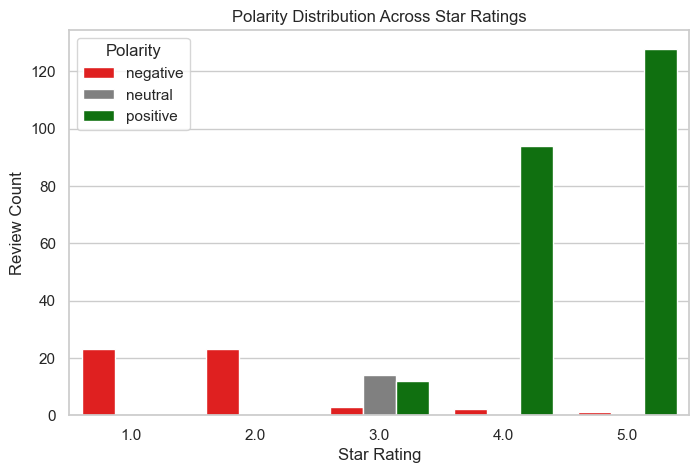

In [42]:
# Polarity distribution in relation to the star as a quick validation of LLM output
sns.set(style="whitegrid")

custom_palette = {
    'positive': 'green',
    'negative': 'red',
    'neutral': 'gray'
}

plt.figure(figsize=(8, 5))
sns.countplot(data=indy_result, x='stars', hue='polarity', palette=custom_palette)
plt.title('Polarity Distribution Across Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Review Count')
plt.legend(title='Polarity')
plt.show()

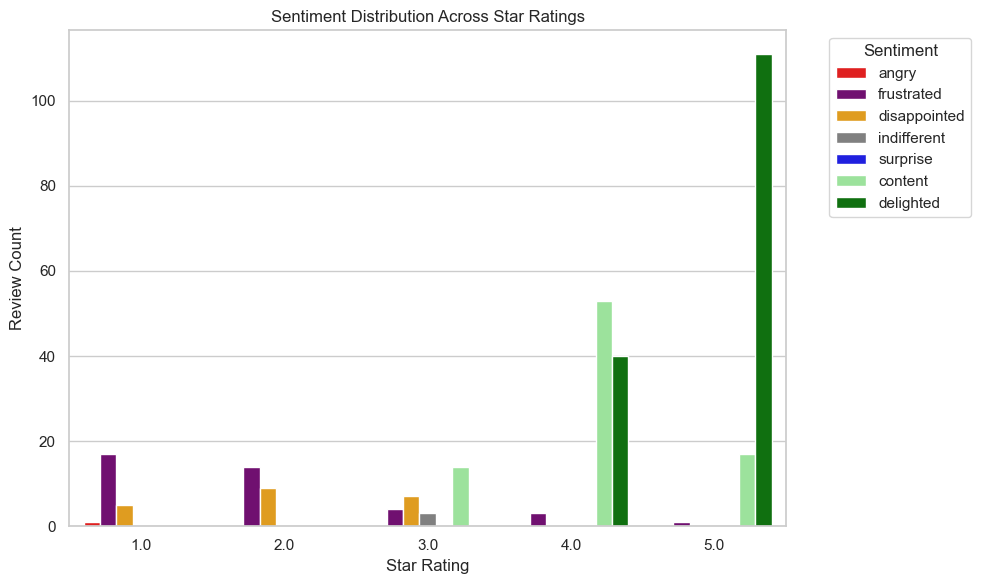

In [43]:
# Define the sentiment display order from most negative to most positive
sentiment_order = ['angry', 'frustrated', 'disappointed', 'indifferent', 'surprise', 'content', 'delighted']

# Use your predefined sentiment color palette
sentiment_palette = {
    'delighted': 'green',
    'content': 'lightgreen',
    'surprise': 'blue',
    'indifferent': 'grey',
    'disappointed': 'orange',
    'angry': 'red',
    'frustrated': 'purple'
}

# Create the count plot for sentiment distribution across star ratings
plt.figure(figsize=(10, 6))
sns.countplot(
    data=indy_result,
    x='stars',
    hue='sentiment',
    hue_order=sentiment_order,
    palette=sentiment_palette
)

plt.title('Sentiment Distribution Across Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Review Count')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Quick exploration of the cause of negative/positive comments using Word Cloud

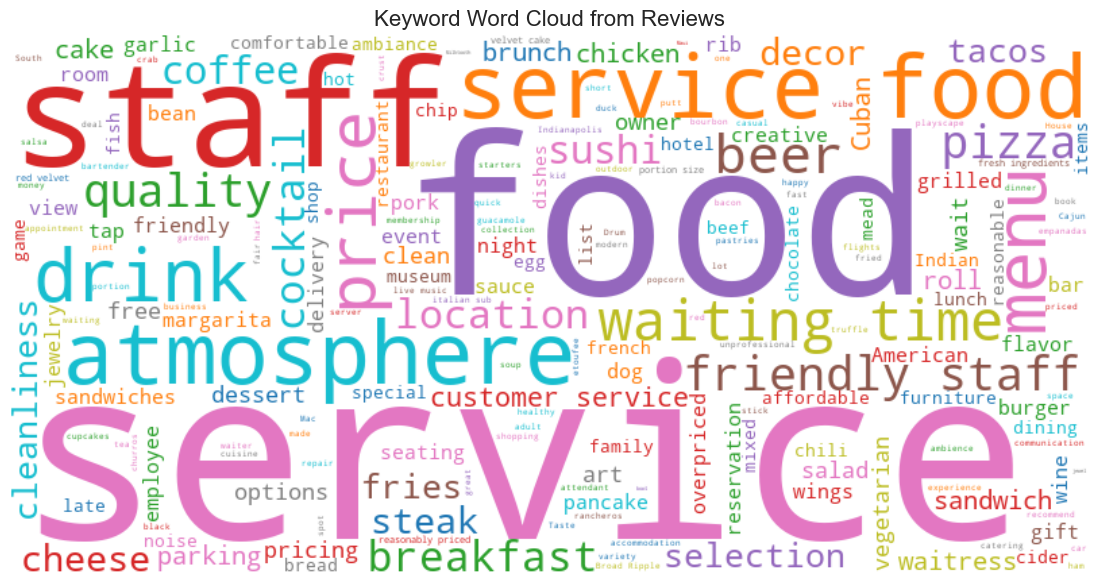

In [44]:
# Make a Wordcloud based on "keywords"
from wordcloud import WordCloud

# Combine all keywords into a single string
all_keywords = ' '.join(indy_result['keywords'].dropna().astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='tab10').generate(all_keywords)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Keyword Word Cloud from Reviews', fontsize=16)
plt.tight_layout()
plt.show()

In [49]:
# Wordcloud grouped by polarity

def plot_wordclouds_by_polarity(df, keyword_col='keywords', polarity_col='polarity'):
    
    polarities = df[polarity_col].dropna().unique()
    num_polarities = len(polarities)

    plt.figure(figsize=(8, 6 * num_polarities))

    for i, polarity in enumerate(sorted(polarities)):
        keywords = df[df[polarity_col] == polarity][keyword_col].dropna().astype(str)
        text = ' '.join(keywords)

        wc = WordCloud(
            width=600, height=300,
            background_color='white',
            collocations=False
        ).generate(text)

        plt.subplot(num_polarities, 1, i + 1)
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Keyword Word Cloud\n({polarity.capitalize()})')

    plt.tight_layout()
    plt.show()

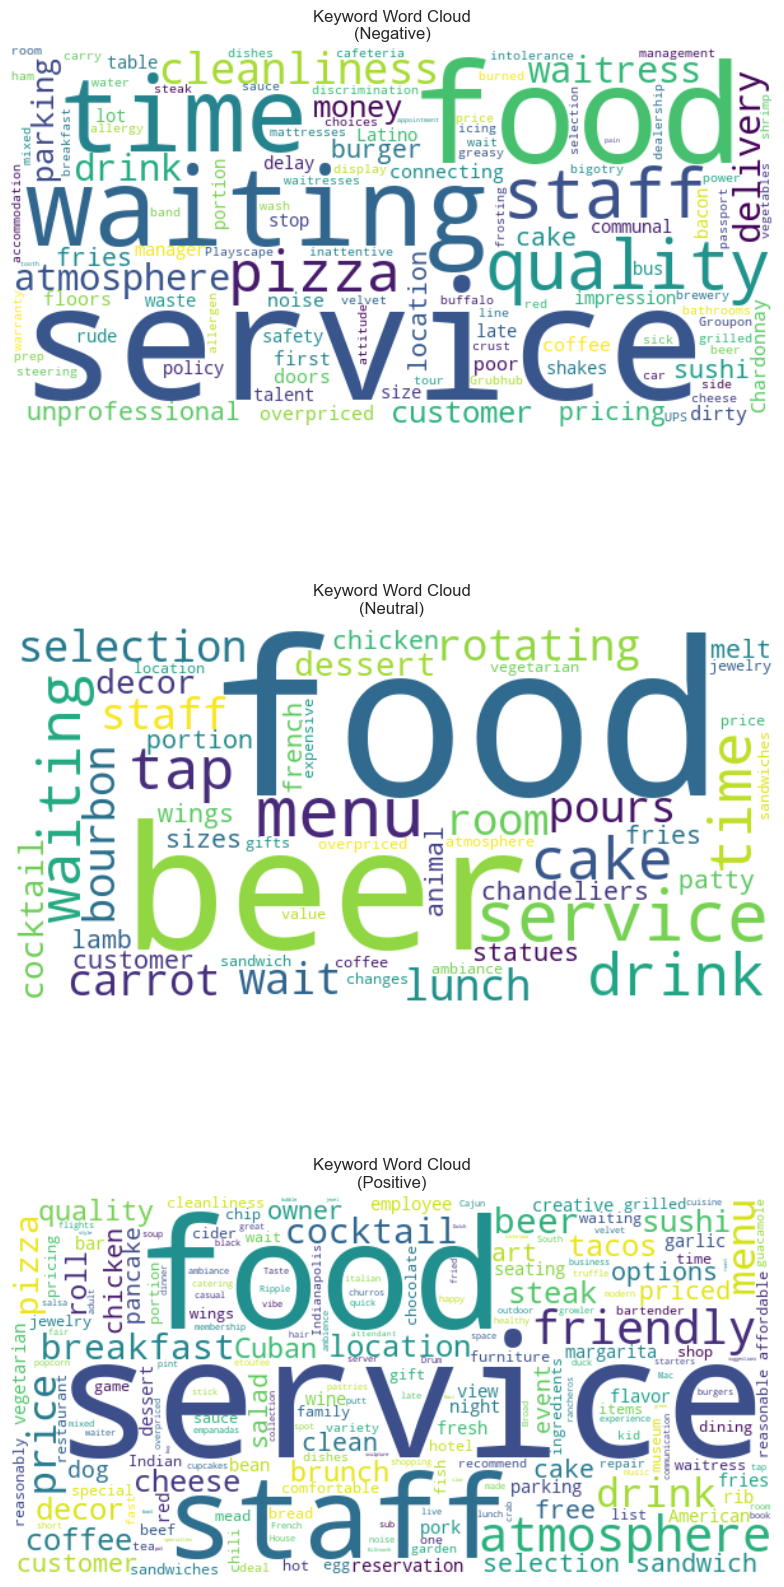

In [50]:
plot_wordclouds_by_polarity(indy_result)